# PREDICTING FAKE NEWS DETECTION USING ML

this notebook looks into various Python based ML and data science libraries in an attempt to build a ML model capable of 
predicting whether news is true or false based on given attributes.



We're going to take following approach :
1. Problem definition/statement
2. Importing Necessary libraries & tools
3. Data loading & cleaning
4. Data Preprocessing
5. modelling

# Problem definition/statement

With the penetration of social media our country is fighting a fake news pandemic. So some brave volunteers took upon the challenge and compiled a list of real and fake news of the past. Now it's your responsibility to create an AI model that can predict if a news is real or fake before it goes viral in social media.

About the Dataset:

1. id: unique id for a news article 
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article, could be incomplete 
5. label: a label that marks whether the news article is real or fake:

1: Fake news

0: real News

### PREPARING THE TOOLS

In [6]:
#import all the tools

# regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import nltk
import re

# module for preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### LOADING DATA

In [7]:
df=pd.read_csv("train.csv")
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [8]:
df.tail()

id                                              title  \
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
20795                              Jerome Hudson   
20796                           Benjamin Hoffman   
20797  Michael J. de la Merced and Rachel Abrams   
20798                                Alex Ansary   
20799                              David Swanson   

                                                    text  label  
20795  Rapper T. I. unloaded on black celebrities who...      0  
20796  When the Green Bay Packers lost to the Washing...      0  
20797  The Macy’s of today grew from the union of sev...      0  
20798  NATO, Russia To Hold Parallel Exercises In Bal...      1  
20799    David Swanson is an author, activist, journa...      1

In [9]:
df["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

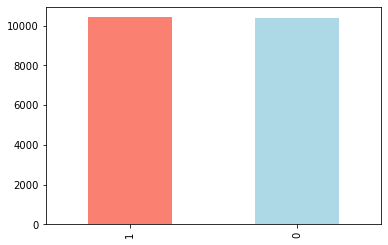

In [10]:
df["label"].value_counts().plot(kind="bar",color=["salmon","lightblue"]);

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [12]:
df.describe()

id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000

In [13]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

### *Since our dataset's target variable is label which is 1 in case of fake news and 0 in case of real news* 
#### Let's calculate the following:

1. Total percentage of 1 and 0 in label column
2. Null author values as per label
3. Label vaues as per empty title and text rows

In [14]:
# There is 50.06% real news and 49.93% fake news
df.label.value_counts(normalize=True)

1    0.500625
0    0.499375
Name: label, dtype: float64

In [15]:
author_empty=df[df["author"].isnull()]
print("Shape of empty author values is:{}".format(author_empty.shape))

Shape of empty author values is:(1957, 5)


In [16]:
# 98% "1" values and 2% "0" values
author_empty["label"].value_counts(normalize=True)

1    0.986714
0    0.013286
Name: label, dtype: float64

In [17]:
text_empty=df[df["text"].isnull()]
print("Shape of empty text values is:{}".format(text_empty.shape))

Shape of empty text values is:(39, 5)


In [18]:
# All the news where there is no text present is fake news
text_empty["label"].value_counts(normalize=True)

1    1.0
Name: label, dtype: float64

In [19]:
title_empty=df[df["title"].isnull()]
print("Shape of empty title values is:{}".format(title_empty.shape))

Shape of empty title values is:(558, 5)


In [20]:
# All the news where there is no title present is fake news
title_empty["label"].value_counts(normalize=True)

1    1.0
Name: label, dtype: float64

In [21]:
df.set_index('id',inplace=True)

In [22]:
author_max=df.author.value_counts()
author_max.index.name="total"
author_max = author_max.to_frame().reset_index()
main_authors=author_max[author_max["author"]>100]
author_real=main_authors.total
authors=df[df.author.isin(author_real)]
authors.label.value_counts(normalize=True)

0    0.897895
1    0.102105
Name: label, dtype: float64

### *Insights from above are as follows:*
1. 98% of the values where the author values are not present represents fake news.
2. Every news where there is absense of title or text is a 100% fake news.
3. Among the authors who have 100+ publications; 89.7% represent real news and 10.3% represents fake news.

In [23]:
df=df.fillna('')

In [24]:
df.head()

title              author  \
id                                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                   Why the Truth Might Get You Fired  Consortiumnews.com   
3   15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                 text  label  
id                                                            
0   House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1   Ever get the feeling your life circles the rou...      0  
2   Why the Truth Might Get You Fired October 29, ...      1  
3   Videos 15 Civilians Killed In Single US Airstr...      1  
4   Print \nAn Iranian woman has been sentenced to...      1

In [25]:
df.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

In [26]:
# Removes Data Duplicates while Retaining the First one
def remove_duplicate(data):
    data.drop_duplicates(keep="first", inplace=True)
    return "Checked Duplicates"

# Removes Duplicates from train data
remove_duplicate(df)

'Checked Duplicates'

In [27]:
# merging the author name and news title
df['Contant']= df['author']+' '+ df['title']

In [28]:
df['Contant']

id
0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: Contant, Length: 20691, dtype: object

In [29]:
# seperating the data and lable 
x= df.drop(columns='label',axis=1)
y= df['label']

In [30]:
x.head()

title              author  \
id                                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                   Why the Truth Might Get You Fired  Consortiumnews.com   
3   15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                 text  \
id                                                      
0   House Dem Aide: We Didn’t Even See Comey’s Let...   
1   Ever get the feeling your life circles the rou...   
2   Why the Truth Might Get You Fired October 29, ...   
3   Videos 15 Civilians Killed In Single US Airstr...   
4   Print \nAn Iranian woman has been sentenced to...   

                                              Contant  
id                                                     
0   Darrell Lucus House Dem Aide: We Didn’t Even S...  
1   Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...  
2   Consortiumnews.com Why the Truth Might Get You...  
3   Jessica Purkiss 15 Civilians Killed In Single ...  
4   Howard Portnoy Iranian woman jailed for fictio...

In [31]:
y.head()

id
0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

## Data Preprocessing

In [32]:
from nltk.stem.porter import PorterStemmer
port_stem= PorterStemmer()

In [40]:
## importing sklearn modules for data Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [33]:
def stemming(content):
    stemmed_content= re.sub('[^a-zA-Z]',' ',content) #for seaching a para or text... sub means subtitue, ^ means exclutiont/remeove int or special character replaced by " " 
    stemmed_content= stemmed_content.lower() #to make all as lower case letter 
    stemmed_content= stemmed_content.split() #it splitted and converted into list 
    stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #removed stopword and stem it 
    stemmed_content= ' '.join(stemmed_content) #once i have done i will join all 
    return stemmed_content

In [34]:
df['Contant']= df['Contant'].apply(stemming)

In [35]:
print(df['Contant'])
print(df['Contant'].dtype)

id
0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: Contant, Length: 20691, dtype: object
object


In [36]:
# seperating the data and label

x= df['Contant'].values
y= df['label'].values

In [37]:
print(x)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [38]:
print(y)

[1 0 1 ... 0 1 1]


In [41]:
#converting the text data to neumwerical data 
vectorizer= TfidfVectorizer()

In [42]:
vectorizer.fit(x) #
x= vectorizer.transform(x)

In [43]:
print(x)

  (0, 15686)	0.28426135218243687
  (0, 13473)	0.25603669745523516
  (0, 8909)	0.3629059155291961
  (0, 8630)	0.29225296888981106
  (0, 7692)	0.2475656884053563
  (0, 7005)	0.21823735188191054
  (0, 4973)	0.23279389989400245
  (0, 3792)	0.26996236127837187
  (0, 3600)	0.3592082110748297
  (0, 2959)	0.2463045634369086
  (0, 2483)	0.3714337764842025
  (0, 267)	0.26996236127837187
  (1, 16799)	0.30061773341516074
  (1, 6816)	0.19078637825470163
  (1, 5503)	0.7141918254203378
  (1, 3568)	0.2636178737261861
  (1, 2813)	0.19139289772625737
  (1, 2223)	0.38267687425953784
  (1, 1894)	0.15504096987647997
  (1, 1497)	0.2942017261171187
  (2, 15611)	0.41536181362013164
  (2, 9620)	0.4934771106665822
  (2, 5968)	0.34753819003893194
  (2, 5389)	0.3869199553865786
  (2, 3103)	0.46091623790913044
  :	:
  (20688, 13122)	0.24823556285386694
  (20688, 12344)	0.2726353671715289
  (20688, 12138)	0.24776516050022307
  (20688, 10306)	0.08024633363443182
  (20688, 9588)	0.1745499729573385
  (20688, 9518)	0.2

## Modelling

In [44]:
# split data into train, test sets
np.random.seed(42)


# split into train and test sets
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, stratify=y, random_state=2)

In [45]:
## logistic regression
model = LogisticRegression()

In [46]:
model.fit(x_train, y_train)

LogisticRegression()

In [47]:
from sklearn.metrics import accuracy_score
#accuracy_score on the trainig data
x_train_prediction= model.predict(x_train) #prediction on values x_train 

training_data_accuracy= accuracy_score(x_train_prediction, y_train)

In [48]:
print("Accuracy Score of the trainig data: ",training_data_accuracy)

Accuracy Score of the trainig data:  0.9868898018366361


In [49]:
#acuracy_ score on the test data
x_test_prediction= model.predict(x_test)
testing_data_accuracy= accuracy_score(x_test_prediction, y_test)

In [50]:
print("Accuracy Score of the test data: ",testing_data_accuracy)

Accuracy Score of the test data:  0.9777724087943948


In [51]:
#building a predictive system
print(x_test[1])

  (0, 16974)	0.3310732410740039
  (0, 16241)	0.3702921402919044
  (0, 16051)	0.38144532736007614
  (0, 14533)	0.26102525849003116
  (0, 13882)	0.2653033579688228
  (0, 4625)	0.1670228587932072
  (0, 3632)	0.19519755413352413
  (0, 3623)	0.20101527848429493
  (0, 2540)	0.2840453943096006
  (0, 1827)	0.38144532736007614
  (0, 1737)	0.3024771630358
  (0, 1064)	0.21253946495612508


In [52]:
x_news = x_test[1]

prediction= model.predict(x_news)
print(prediction)

if prediction[0]==0:
    print("News is real")
else:
    print("News is fake")

[1]
News is fake


## Testing it from Y_test Col for confirmation of result 
### Where 0 stands for real news and 1 stands for Fake news 

print(y_test[1])

In [53]:
#saving the trained model

import pickle

In [54]:
filename='Trained_model.pkl'
pickle.dump(model, open(filename,'wb'))

In [55]:
#loading a saved model

loaded_model= pickle.load(open('Trained_model.pkl','rb'))

## Accuracy score on the test data with Logistic Regression Model

In [56]:
x_test_prediction= loaded_model.predict(x_test)
testing_data_accuracy= accuracy_score(x_test_prediction, y_test)

In [57]:
print(testing_data_accuracy)

0.9777724087943948
